In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../../edit-pathways/')
from util import util_data_fetching_for_app as udf
from importlib import reload
reload(udf)

In [3]:
data_pathway = "../../edit-pathways/data/diffengine-diffs/spark-output/"

In [11]:
! gunzip $data_pathway/ap-matched-sentences.db.gz 

In [4]:
conn = sqlite3.connect(data_pathway + 'ap-matched-sentences.db')
pd.read_sql('SELECT * FROM sqlite_master;', con=conn)

,type,name,tbl_name,rootpage,sql
0,table,matched_sentences,matched_sentences,2,"CREATE TABLE ""matched_sentences"" (\n""entry_id""..."
1,table,split_sentences,split_sentences,11522,"CREATE TABLE ""split_sentences"" (\n""entry_id"" I..."


In [5]:
pd.read_sql('select * from matched_sentences limit 2', con=conn)

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance_x,avg_sentence_distance_y
0,3876,2,3,6.0,12.0,2.548959e-07,2.548959e-07
1,3902,21,22,4.0,NaN,NaN,NaN


In [6]:
pd.read_sql('select * from split_sentences limit 2', con=conn)

,entry_id,version,sent_idx,sentence
0,17808,4.0,0,<p> ATLANTA (AP) -- Bobby Brown often broke in...
1,17808,4.0,1,"</p> <p>""You never really get over it,"" he sai..."


# Find all documents that start small and grow

In [7]:
pd.read_sql('select * from matched_sentences limit 5', con=conn)

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance_x,avg_sentence_distance_y
0,3876,2,3,6.0,12.0,2.548959e-07,2.548959e-07
1,3902,21,22,4.0,NaN,NaN,NaN
2,3730,6,7,17.0,17.0,0.000000e+00,0.000000e+00
3,3572,5,6,35.0,NaN,NaN,NaN
4,4217,5,6,43.0,60.0,0.000000e+00,0.000000e+00


In [8]:
num_added_and_deleted = pd.read_sql('''
    SELECT
        entry_id,
        version_x,
        version_y,
        COUNT(DISTINCT sent_idx_x) as num_sents_x,
        COUNT(DISTINCT sent_idx_y) as num_sents_y,        
        SUM(sent_idx_y IS NULL) as num_deleted,
        SUM(sent_idx_x IS NULL) as num_added
    FROM matched_sentences 
    GROUP BY entry_id, version_x, version_y
''', con=conn).assign(growth=lambda df: df['num_added'] - df['num_deleted'])

[]

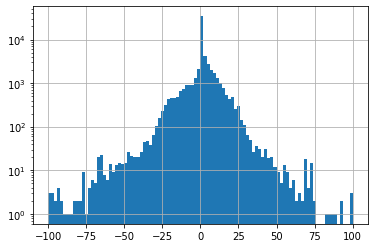

In [38]:
num_added_and_deleted['growth'].hist(bins=100, range=(-100, 100))
plt.semilogy()

In [9]:
num_added_and_deleted

,entry_id,version_x,version_y,num_sents_x,num_sents_y,num_deleted,num_added,growth
0,1,0,1,45,47,0,1,1
1,1,1,2,47,43,8,4,-4
2,2,0,1,40,40,1,1,0
3,2,1,2,40,40,0,0,0
4,2,2,3,33,69,33,69,36
...,...,...,...,...,...,...,...,...
61513,23075,0,1,13,15,0,2,2
61514,23075,1,2,15,15,1,1,0
61515,23076,0,1,6,6,0,0,0
61516,23077,0,1,7,30,5,28,23


In [30]:
udf.dump_output_to_app_readable(output, '../app/data/sample-data.json')

In [205]:
import glob
files = glob.glob(data_pathway + '/*')

In [206]:
files

['../../edit-pathways/data/diffengine-diffs/spark-output/ap-matched-sentences.db.gz',
 '../../edit-pathways/data/diffengine-diffs/spark-output/independent-matched-sentences.db.gz',
 '../../edit-pathways/data/diffengine-diffs/spark-output/bbc-2-matched-sentences.db.gz',
 '../../edit-pathways/data/diffengine-diffs/spark-output/nyt-matched-sentences.db',
 '../../edit-pathways/data/diffengine-diffs/spark-output/reuters-matched-sentences.db.gz',
 '../../edit-pathways/data/diffengine-diffs/spark-output/guardian-matched-sentences.db.gz',
 '../../edit-pathways/data/diffengine-diffs/spark-output/wp-matched-sentences.db.gz']

In [207]:
# ('bbc', 848918, 1, 2)

In [208]:
all_output = []
all_matched_sents = []
all_split_sents = []
all_num_added_and_deleted = []
for f in files:
    source = f.split('/')[-1].split('-')[0]
    print('doing %s' % source)
    if '.gz' in f:
        ! gunzip $f
        f = f.replace('.gz', '')

    conn = sqlite3.connect(f)
    num_added_and_deleted = pd.read_sql('''
        SELECT
            entry_id,
            version_x,
            version_y,
            COUNT(DISTINCT sent_idx_x) as num_sents_x,
            COUNT(DISTINCT sent_idx_y) as num_sents_y,        
            SUM(sent_idx_y IS NULL) as num_deleted,
            SUM(sent_idx_x IS NULL) as num_added
        FROM matched_sentences 
        GROUP BY entry_id, version_x, version_y
    ''', con=conn).assign(growth=lambda df: df['num_added'] - df['num_deleted'])
    
    num_added_and_deleted['source'] = source
    all_num_added_and_deleted.append(num_added_and_deleted)
    
    candidate_set = (
        num_added_and_deleted
         .loc[lambda df: (df['growth'] > 2) & (df['growth'] < 10) &
                         (df['num_deleted'] < 5) 
#                          & (df['version_x'] < 10) 
#                          & (df['num_sents_x'] < 20)
#                          & (df['num_sents_x'] > 3)
         ]
    )
    
    join_keys = udf.get_join_keys(candidate_set)
    matched_sentences, split_sentences = udf.get_data_from_sqlite_by_sentence_criteria(source, conn, join_keys)
    output = udf.match_sentences(matched_sentences, split_sentences)
    
    all_matched_sents.append(matched_sentences)
    all_split_sents.append(split_sentences)
    all_output.append(output)
    
    # zipping up again 
    ! gzip $f

doing ap
doing independent
doing bbc
doing nyt
doing reuters
doing guardian
doing wp


In [209]:
all_matched_sents_df = pd.concat(all_matched_sents)

In [210]:
all_output_df = pd.concat(all_output)

In [211]:
all_split_sents_df = pd.concat(all_split_sents)

In [212]:
all_num_added_and_deleted_df = pd.concat(all_num_added_and_deleted)

In [213]:
all_output_df.head()

nodes  \
source entry_id version_x version_y                                                      
ap     4        0         1          [{'version': 0, 'sent_idx': 0, 'sentence': 'HO...   
                1         2          [{'version': 1, 'sent_idx': 0, 'sentence': 'HO...   
                7         8          [{'version': 7, 'sent_idx': 0, 'sentence': 'HO...   
                13        14         [{'version': 13, 'sent_idx': 0, 'sentence': 'H...   
                14        15         [{'version': 14, 'sent_idx': 0, 'sentence': 'H...   

                                                                                  arcs  
source entry_id version_x version_y                                                     
ap     4        0         1          [{'version_x': 0, 'version_y': 1, 'sent_idx_x'...  
                1         2          [{'version_x': 1, 'version_y': 2, 'sent_idx_x'...  
                7         8          [{'version_x': 7, 'version_y': 8, 'sent_idx_x'...  
                13        14         [{'version_x': 13, 'version_y': 14, 'sent_idx_...  
                14        15         [{'version_x': 14, 'version_y': 15, 'sent_idx_...

In [215]:
all_output_df.shape 

(288994, 2)

In [219]:
mkdir ../eda/data

In [220]:
all_split_sents_df.to_csv('../eda/data/sentences-for-discourse-modelings.csv.gz', compression='gzip')

In [221]:
all_matched_sents_df.to_csv('../eda/a/data/matched-sentences-for-discourse-modeling.csv.gz', compression='gzip')

In [222]:
all_output_df.to_pickl../eda//eda/data/all-output-df.pkl')

In [72]:
udf.dump_output_to_app_readable(all_output_df, '../app/data/breaking-news-data.json')

In [87]:
import numpy as np

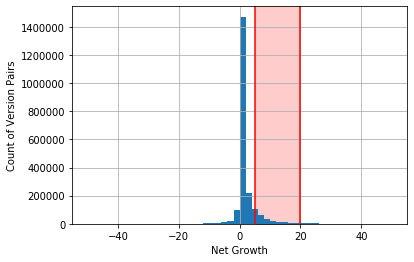

In [100]:
all_num_added_and_deleted_df['growth'].hist(bins=50, range=(-50, 50))
plt.ylabel('Count of Version Pairs')
plt.xlabel('Net Growth')
ymin, ymax = plt.ylim()
plt.vlines(5, ymin, ymax, color='r')
plt.vlines(20, ymin, ymax, color='r')
plt.ylim(ymin, ymax)
plt.fill_between(np.arange(5, 21), ymin, ymax, color='r', alpha=.2)

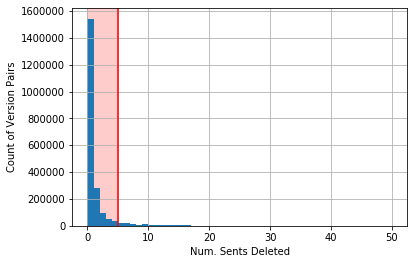

In [101]:
all_num_added_and_deleted_df['num_deleted'].hist(bins=50, range=(0, 50))
plt.ylabel('Count of Version Pairs')
plt.xlabel('Num. Sents Deleted')
ymin, ymax = plt.ylim()
plt.vlines(5, ymin, ymax, color='r')
plt.ylim(ymin, ymax)
plt.fill_between(np.arange(0, 6), ymin, ymax, color='r', alpha=.2)

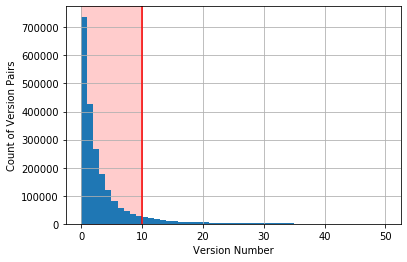

In [102]:
all_num_added_and_deleted_df['version_x'].hist(bins=50, range=(0, 50))
plt.ylabel('Count of Version Pairs')
plt.xlabel('Version Number')
ymin, ymax = plt.ylim()
plt.vlines(10, ymin, ymax, color='r')
plt.ylim(ymin, ymax)
plt.fill_between(np.arange(0, 11), ymin, ymax, color='r', alpha=.2)

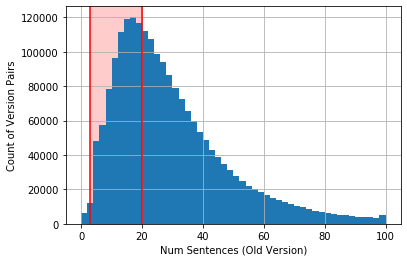

In [103]:
all_num_added_and_deleted_df['num_sents_x'].hist(bins=50, range=(0, 100))
plt.ylabel('Count of Version Pairs')
plt.xlabel('Num Sentences (Old Version)')
ymin, ymax = plt.ylim()
plt.vlines(3, ymin, ymax, color='r')
plt.vlines(20, ymin, ymax, color='r')
plt.ylim(ymin, ymax)
plt.fill_between(np.arange(3, 21), ymin, ymax, color='r', alpha=.2)

In [ ]:
ls $data_pathway/../db/

In [116]:
! gzip $data_pathway/../db/ap.db

In [117]:
files = glob.glob(data_pathway + '/../db/*')

In [127]:
files = list(filter(lambda x: 'newssniffer' in x or ('ap.db.gz' in x) or ('reuters' in x), files))

In [ ]:
files

In [ ]:
all_created = []
for f in files:
    source = f.split('/')[-1].split('-')[-1].replace('.db.gz', '')
    print('doing %s' % source)
    if '.gz' in f:
        ! gunzip $f
        f = f.replace('.gz', '')

    conn = sqlite3.connect(f)
    created = pd.read_sql('select entry_id, version, created from entryversion', con=conn)
    
    created['source'] = source
    all_created.append(created)
    
    ! gzip $f

In [137]:
all_created_time_df = pd.concat(all_created).assign(created=lambda df: pd.to_datetime(df['created']))

In [138]:
all_created_time_df = (
    all_created_time_df
     .merge(
         all_created_time_df.assign(new_version=lambda df: df['version'] - 1),
         left_on=['source', 'entry_id', 'version'],
         right_on=['source', 'entry_id', 'new_version']
        )
)

In [140]:
all_created_time_df['diff'] = all_created_time_df.pipe(lambda df: df['created_y'] - df['created_x'])

In [149]:
all_created_time_df['diff'] = all_created_time_df['diff'].apply(lambda x: x.total_seconds())

In [170]:
name_mapper = {'washpo':'wp',
'nytimes':'nyt'}

In [173]:
merged_created_time_df = all_created_time_df.merge(
    all_output_df.reset_index().assign(source=lambda df: df['source'].apply(lambda x: name_mapper.get(x, x))),
    right_on=['source', 'entry_id', 'version_x', 'version_y'], 
    left_on=['source', 'entry_id', 'version_x', 'version_y'], 
)

In [184]:
import seaborn as sns

Text(0.5, 0, 'Hours Between Versions')

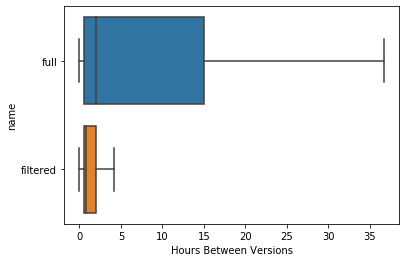

In [187]:
pd.concat([
    (all_created_time_df['diff'] / (60 * 60)).to_frame('diff').assign(name='full'),
    (merged_created_time_df['diff'] / (60 * 60)).to_frame('diff').assign(name='filtered')
]).pipe(lambda df: sns.boxplot(y='name', x='diff', data=df, showfliers=False))
plt.xlabel('Hours Between Versions')

In [188]:
all_output_df.shape 

(64194, 2)

# Inspect

In [195]:
key = ('bbc', 848918, 1, 2)

In [196]:
all_output_df.loc[key]

nodes    [{'version': 1, 'sent_idx': 0, 'sentence': '1....
arcs     [{'version_x': 1, 'version_y': 2, 'sent_idx_x'...
Name: (bbc, 848918, 1, 2), dtype: object

In [198]:
(all_num_added_and_deleted_df
 .set_index(['source', 'entry_id', 'version_x', 'version_y'])
 .loc[key]
)

num_sents_x     9
num_sents_y    22
num_deleted     0
num_added      13
growth         13
Name: (bbc, 848918, 1, 2), dtype: int64

In [ ]:
(df['growth'] > 5) & (df['growth'] < 20)
(df['num_deleted'] < 5) & (df['version_x'] < 10)
(df['num_sents_x'] < 20) & (df['num_sents_x'] > 3)


In [31]:
entry_id = 22962
version_x = 0
version_y = 1
pd.read_sql('''
    SELECT * FROM matched_sentences 
        WHERE entry_id = %s 
            AND version_x = %s
            AND version_y = %s
''' % (entry_id, version_x, version_y), con=conn)

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance_x,avg_sentence_distance_y
0,22962,0,1,26.0,40.0,0.000000e+00,0.000000e+00
1,22962,0,1,14.0,24.0,0.000000e+00,0.000000e+00
2,22962,0,1,6.0,18.0,NaN,0.000000e+00
3,22962,0,1,20.0,33.0,1.731226e-01,1.731226e-01
4,22962,0,1,18.0,30.0,1.694458e-01,1.694458e-01
5,22962,0,1,NaN,16.0,NaN,NaN
6,22962,0,1,3.0,6.0,4.937028e-07,4.937028e-07
7,22962,0,1,17.0,27.0,6.721860e-07,6.721860e-07
8,22962,0,1,5.0,12.0,0.000000e+00,0.000000e+00
9,22962,0,1,NaN,2.0,NaN,NaN


In [32]:
pd.read_sql('SELECT sentence from split_sentences WHERE entry_id = %s and version = %s' % (entry_id, version_x), con=conn)['sentence'].values

array(['<p>COLLEGE STATION, Texas (AP) — Kelly Bryant threw for 205 yards and a touchdown and ran for another score to help No. 2 Clemson escape with a 28-26 victory over Kellen Mond and Texas A&amp;',
       'M on Saturday night.',
       '</p> <p>Mond was spectacular in the second half, throwing for three touchdowns, with a 14-yard pass to Kendrick Rogers cutting the lead to 28-26 with 46 seconds left.',
       'But his big performance came up just short when the 2-point conversion attempt was intercepted in the end zone.',
       '</p> <p>"The moment was not too big for him .', '.', '.',
       'his composure in the game and his decision-making was excellent," Texas A&amp;',
       'M coach Jimbo Fisher said.',
       'Clemson coach Dabo Swinney said it was a shame anyone had to lose this one.',
       '</p> <p>"I thought we had opportunities to really get control of the game in the first half and we didn\'t take advantage of it," Swinney said.',
       '</p> <p>Mond finished with a

In [33]:
pd.read_sql('SELECT sentence from split_sentences WHERE entry_id = %s and version = %s' % (entry_id, version_y), con=conn)['sentence'].values

array(['<p>COLLEGE STATION, Texas (AP) — Time after time, No. 2 Clemson missed opportunities to close out Texas A&amp;',
       'M.',
       '</p> <p>In the end, the Tigers stepped up and made the one play they had to make to secure the thrilling win.',
       '</p> <p>Kelly Bryant threw for 205 yards and a touchdown and ran for another score to help Clemson escape with the 28-26 victory.',
       '</p> <p>Texas A&amp;',
       'M quarterback Kellen Mond was spectacular in the second half , throwing for three touchdowns, with a 14-yard pass to Kendrick Rogers cutting the lead to 28-26 with 46 seconds left.',
       'But his big performance came up just short when the 2-point conversion attempt was intercepted in the end zone.',
       '"At the end of the day, it came down to the two-point play, and we got the interception," coach Dabo Swinney said.',
       '</p> <p>Texas A&amp;',
       "M coach Jimbo Fisher was impressed with his sophomore quarterback's performance.",
       '</p> <p